# 📚 Notebook 6.1: Fine-Tune GPT-2 for Text Classification

Welcome back to the series! 🎉 Now that we’ve explored advanced training techniques in *Notebook 5.2*, it's time to take our GPT-2 model a step further by fine-tuning it for a specific, practical application: **text classification**.

### What's the Goal? 🏆

In this notebook, we will adapt the GPT-2 model to classify text data—a departure from its primary generative capabilities. Fine-tuning a language model like GPT-2 for classification opens up applications in areas such as **spam detection, sentiment analysis, and topic categorization**. This hands-on approach provides insight into how transformer-based models can be repurposed for a wide range of NLP tasks.

### What's Inside? 🔍

This notebook is structured to bridge the gap between **general language modeling** and **task-specific fine-tuning**. Here’s what we’ll cover:

#### **Section 1: Data Preparation for Classification** 📊
In this section, we'll focus on:
- Structuring our dataset for text classification tasks
- Tokenizing and batching the data to optimize training

#### **Section 2: Fine-Tuning GPT-2** 🔄
Building on the advanced training methods from *Notebook 5.2*, we’ll apply techniques such as:
- Layer freezing and selective unfreezing to control the depth of fine-tuning
- Adapting the optimizer and scheduler configurations for stability and performance

#### **Section 3: Evaluation and Analysis** 📈
After training, we’ll assess our model’s performance through:
- Accuracy, precision, recall, and F1-score evaluations
- Visualization of the model’s classification behavior and confusion matrix



Let’s get started and explore how to make GPT-2 shine as a text classifier! 🌟

# Introduction to Fine-Tuning

Fine-tuning is a crucial process in machine learning that involves adapting a pre-trained model, which has already learned from a large dataset, to a specific task or dataset. Instead of starting from scratch, fine-tuning utilizes the patterns and representations learned during initial training, enabling the model to quickly learn task-specific features with less data.

## Key Aspects of Fine-Tuning:

- **Efficiency**: Fine-tuning requires fewer resources and time compared to training a new model from the ground up.
- **Transfer Learning**: The model retains the broader knowledge gained during pre-training, which enhances its performance on specific tasks.
- **Application in NLP**: In natural language processing (NLP), models like GPT-2 are often fine-tuned for tasks such as text classification, sentiment analysis, or summarization.

By leveraging a solid foundation of linguistic and contextual understanding, fine-tuning enables models to achieve high performance on specialized tasks while minimizing the data and computational power required.

<p align="center">
    <img src="images/finetine.png" alt="My Image" />
</p>

## LETS GET STARTED 🚀

In [1]:
# Importing the version function from the importlib.metadata module
from importlib.metadata import version

# List of essential packages for the project
pkgs = [
    "matplotlib",  # For creating static, animated, and interactive visualizations in Python
    "numpy",       # A fundamental package for scientific computing with support for large, multi-dimensional arrays and matrices
    "tiktoken",    # Tokenization library used for preparing text data for models like GPT-2
    "torch",       # PyTorch library for building and training neural networks
    "tensorflow",  # For loading OpenAI's pretrained weights and performing other tasks
    "pandas"       # Data manipulation and analysis library, useful for loading and handling datasets
]


## Different categories of finetuning

- The most common ways to finetune language models are instruction-finetuning and classification finetuning
- Instruction-finetuning, depicted below, is the topic of the next notebook

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/instructions.webp" width=500px>

- Classification finetuning, the topic of this chapter, is a procedure you may already be familiar with if you have a background in machine learning -- it's similar to training a convolutional network to classify handwritten digits, for example
- In classification finetuning, we have a specific number of class labels (for example, "spam" and "not spam") that the model can output
- A classification finetuned model can only predict classes it has seen during training (for example, "spam" or "not spam"), whereas an instruction-finetuned model can usually perform many tasks
- We can think of a classification-finetuned model as a very specialized model; in practice, it is much easier to create a specialized model than a generalist model that performs well on many different tasks

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/spam-non-spam.webp" width=500px>

## STEP 1 :  Preparing the dataset




- This section prepares the dataset we use for classification finetuning
- We use a dataset consisting of spam and non-spam text messages to finetune the LLM to classify them
- First, we download and unzip the dataset

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

# URL of the dataset zip file
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"  # Local path to save the downloaded zip file
extracted_path = "sms_spam_collection"  # Directory to extract the contents of the zip file
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"  # Final path of the TSV file

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    # Check if the data file already exists
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the zip file
    print("Downloading the dataset...")
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the downloaded file
    print("Extracting the dataset...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Renaming the original file to add the .tsv extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

# Call the function to download and extract the dataset
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


Extracting the dataset...
File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


- The dataset is saved as a tab-separated text file, which we can load into a pandas DataFrame

In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- When we check the class distribution, we see that the data contains "ham" (i.e., "not spam") much more frequently than "spam"

In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- For simplicity, and because we prefer a small dataset for educational purposes anyway (it will make it possible to finetune the LLM faster), we subsample (undersample) the dataset so that it contains 747 instances from each class
- (Next to undersampling, there are several other ways to deal with class balances, you may refer to sklearn exllent docs on this subject(https://imbalanced-learn.org/stable/user_guide.html))

In [5]:
def create_balanced_dataset(df):
    # Count the instances of "spam"
    num_spam = df[df["Label"] == "spam"].shape[0]

    # Randomly sample "ham" instances to match the number of "spam" instances
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # Combine the sampled ham subset with all spam instances
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

# Assuming df is your DataFrame containing the dataset
balanced_df = create_balanced_dataset(df)

# Print the value counts to verify the balance
print(balanced_df["Label"].value_counts())


Label
ham     747
spam    747
Name: count, dtype: int64


- Next, we change the string class labels "ham" and "spam" into integer class labels 0 and 1:

In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})
balanced_df["Label"]

,Label
4307,0
4138,0
4831,0
4461,0
5440,0
...,...
5537,1
5540,1
5547,1
5566,1


- Let's now define a function that randomly divides the dataset into training, validation, and test subsets using the good old sklerarn

In [41]:
from sklearn.model_selection import train_test_split

# Assuming 'balanced_df' is your DataFrame and the labels are in the 'Label' column
# Make a copy to avoid modifying the original DataFrame
data = balanced_df.copy()

# First, split the data into training (70%) and temporary (30%)
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=123, stratify=data["Label"])

# Then, split the temporary data into validation (10%) and test (20%)
val_data, test_data = train_test_split(temp_data, test_size=0.6667, random_state=123, stratify=temp_data["Label"])

# Save the splits to CSV files with both inputs and targets
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)

# Display the shape of the splits
print(f"Training set shape: {train_data.shape}")  # Includes input and target
print(f"Validation set shape: {val_data.shape}")  # Includes input and target
print(f"Test set shape: {test_data.shape}")        # Includes input and target


Training set shape: (1045, 2)
Validation set shape: (149, 2)
Test set shape: (300, 2)


## Creating data loaders

- Note that the text messages have different lengths; if we want to combine multiple training examples in a batch, we have to either
  1. truncate all messages to the length of the shortest message in the dataset or batch
  2. pad all messages to the length of the longest message in the dataset or batch

- We choose option 2 and pad all messages to the longest message in the dataset


In [42]:

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- The `SpamDataset` class below identifies the longest sequence in the training dataset and adds the padding token to the others to match that sequence length

In [ ]:
from torch.utils.data import Dataset
import torch

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        """
        Initializes the SpamDataset.

        Args:
            csv_file (str): Path to the CSV file containing the dataset.
            tokenizer: The tokenizer used to encode the text data.
            max_length (int, optional): Maximum length of the encoded sequences.
                                         If None, the longest sequence will be used.
            pad_token_id (int, optional): Token ID used for padding (default is 50256).
        """
        self.data = pd.read_csv(csv_file)  # Load data from the CSV file

        # Pre-tokenize texts using the provided tokenizer
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        # Determine the maximum length for encoding
        if max_length is None:
            self.max_length = self._longest_encoded_length()  # Set max length to the longest encoded length
        else:
            self.max_length = max_length
            # Truncate sequences if they are longer than max_length
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pad sequences to ensure they all have the same length
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        """
        Retrieves the encoded text and its corresponding label.

        Args:
            index (int): Index of the item to retrieve.

        Returns:
            tuple: A tuple containing:
                - torch.Tensor: The encoded text as a tensor.
                - torch.Tensor: The corresponding label as a tensor.
        """
        encoded = self.encoded_texts[index]  # Get the encoded text at the specified index
        label = self.data.iloc[index]["Label"]  # Get the corresponding label
        return (
            torch.tensor(encoded, dtype=torch.long),  # Convert encoded text to a tensor
            torch.tensor(label, dtype=torch.long)     # Convert label to a tensor
        )

    def __len__(self):
        """Returns the total number of samples in the dataset."""
        return len(self.data)  # Return the length of the dataset

    def _longest_encoded_length(self):
        """
        Calculates the length of the longest encoded text.

        Returns:
            int: The length of the longest encoded text.
        """
        max_length = 0  # Initialize max_length to 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)  # Get the length of the current encoded text
            if encoded_length > max_length:
                max_length = encoded_length  # Update max_length if the current length is greater
        return max_length  # Return the longest length found


In [44]:
train_dataset = SpamDataset(
    csv_file="train_data.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- We also pad the validation and test set to the longest training sequence
- Note that validation and test set samples that are longer than the longest training example are being truncated via `encoded_text[:self.max_length]` in the `SpamDataset` code
- This behavior is entirely optional, and it would also work well if we set `max_length=None` in both the validation and test set cases

In [45]:
val_dataset = SpamDataset(
    csv_file="val_data.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test_data.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [46]:
import torch
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- As a verification step, we iterate through the data loaders and ensure that the batches contain 8 training examples each, where each training example consists of 120 tokens

In [47]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- Lastly, let's print the total number of batches in each dataset

In [48]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## Step 2 :  Initializing a model with pretrained weights

lets set up the model configration

In [49]:
# Choose the model to use
CHOOSE_MODEL = "gpt2-small (124M)"

# Base configuration settings for the model
BASE_CONFIG = {
    "vocab_size": 50257,     # Size of the vocabulary used by the model
    "context_length": 1024,  # Maximum context length the model can handle
    "drop_rate": 0.0,        # Dropout rate for regularization
    "qkv_bias": True         # Whether to use bias terms in query, key, and value projections
}

# Dictionary containing configurations for different GPT-2 model sizes
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},      # Config for small model
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},    # Config for medium model
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},     # Config for large model
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},       # Config for extra-large model
}

# Update the BASE_CONFIG with parameters specific to the chosen model
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

# Assert to check that the maximum length of the training dataset does not exceed the model's context length
assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Dataset length {train_dataset.max_length} exceeds model's context "
    f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
    f"`max_length={BASE_CONFIG['context_length']}`"
)


### Loading the GPT Model

In this section, we will accomplish the following:

1. **Load the GPT model** that we built from scratch in the previous notebooks.
2. **Utilize utility functions** to download and integrate the model weights.

**Important Notes:**

- All relevant code is located in the `UTILS` folder within the same directory.
- The functions `download_and_load_gpt2` and `load_weights_into_gpt` are derived from Sebastian Raschka, the author of *Building LLMs from Scratch*. You can find the source link in the code comments.
- Alternatively, you can load the weights using Hugging Face's library; however, I prefer this method for its intuitive approach and deeper understanding of the underlying processes.


In [ ]:
from UTILS.load_weights import download_and_load_gpt2 , load_weights_into_gpt
from UTILS.model import GPTModel

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


- To ensure that the model was loaded correctly, let's double-check that it generates coherent text

- As we can see, the model is not very good at following instructions
- This is expected, since it has only been pretrained and not instruction-finetuned (instruction finetuning will be covered in the next chapter)

## Step 3 : Adding a classification head (and freezing the model)

<p align="center">
    <img src="images/classification_finetune.png" alt="My Image" />
</p>

- In this section, we are modifying the pretrained LLM to make it ready for classification finetuning
- Let's take a look at the model architecture first

In [53]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In this section, we will focus on the model we built in Notebook 3. Our objectives are as follows:

1. **Freeze the Model Graph**: We will freeze the model's parameters to prevent retraining the entire architecture, which helps retain the knowledge learned during initial training.

2. **Replace the Final Layer**: We will replace the final layer (`out_head`) with a new classification layer tailored for our specific task.

3. **Unfreeze Specific Layers**: To enhance model performance, we will strategically unfreeze additional layers closer to the output. Specifically, we will unfreeze the last layer of the transformer block as well as the final layer normalization (`final_norm`). This approach is expected to yield better results by allowing the model to adapt more effectively to our dataset.


In [54]:
# 1- Freeze the Model Graph
for param in model.parameters():
    param.requires_grad = False

# 2- Replace the Final Layer
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

# 3- Unfreeze last transformer block  and final normalization Layers
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

## Step 4 :  Calculating the classification loss and accuracy

- We can apply this concept to calculate the so-called classification accuracy, which computes the percentage of correct predictions in a given dataset
- To calculate the classification accuracy, we can apply the preceding `argmax`-based prediction code to all examples in a dataset and calculate the fraction of correct predictions as follows:

Let’s create a mock-up tensor to explain how the accuracy calculation works in the `calc_accuracy_loader` function. We will simulate some input and target data, and then step through the function while calculating the accuracy based on this mock data.

### Mock Data

We’ll create:
- **Input Tensor**: Simulated model predictions (logits).
- **Target Tensor**: True labels for the data.


**Predicted Labels**:
   We apply the `argmax` operation to the logits to determine the predicted class for each sample.`

   The `predicted_labels` will be:
   - Sample 1: 0 (correct)
   - Sample 2: 1 (correct)
   - Sample 3: 2 (correct)
   - Sample 4: 0 (incorrect, true label is 1)

In [11]:
# Mock input tensor representing model predictions (logits)
# Shape: (batch_size, num_classes)
# Here, we assume a batch size of 4 and 3 classes.
input_logits = torch.tensor([
    [2.0, 1.0, 0.1],  # Sample 1: class 0 is predicted
    [0.5, 2.0, 0.5],  # Sample 2: class 1 is predicted
    [0.2, 0.1, 3.0],  # Sample 3: class 2 is predicted
    [0.0, 0.0, 0.0]   # Sample 4: no prediction (edge case)
])

# Mock target tensor representing true labels
# Shape: (batch_size,)
true_labels = torch.tensor([0, 1, 2, 1])  # True classes for the 4 samples

# Convert logits to predicted labels using argmax
predicted_labels = torch.argmax(input_logits, dim=-1)

predicted_labels = torch.argmax(input_logits, dim=-1)
print(predicted_labels)  # Output: tensor([0, 1, 2, 0])

tensor([0, 1, 2, 0])


**Counting Correct Predictions**:
   Now we compare the predicted labels with the true labels to count how many predictions are correct.

 
   The comparison will yield:
   - Sample 1: Correct (predicted 0, true 0)
   - Sample 2: Correct (predicted 1, true 1)
   - Sample 3: Correct (predicted 2, true 2)
   - Sample 4: Incorrect (predicted 0, true 1)

   So, there are 3 correct predictions out of 4 samples.


In [12]:
 
correct_predictions = (predicted_labels == true_labels).sum().item()
print(correct_predictions)  # Output: 3
  


3



4. **Calculating Accuracy**:
   Finally, we calculate accuracy by dividing the number of correct predictions by the total number of samples.


   The accuracy calculation will be:
   \[
   \text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Samples}} = \frac{3}{4} = 0.75
   \]

In [13]:

num_examples = true_labels.shape[0]  # Total number of samples
accuracy = correct_predictions / num_examples
print(f"Accuracy: {accuracy:.2f}")  # Output: Accuracy: 0.75


Accuracy: 0.75


Now lets implement in a consice function :

In [55]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # Logits of last output token
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

- Let's apply the function to calculate the classification accuracies for the different datasets:

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# As of this writing, in PyTorch 2.4, the results obtained via CPU and MPS were identical.
# However, in earlier versions of PyTorch, you may observe different results when using MPS.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#print(f"Running on {device} device.")

model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 62.50%
Test accuracy: 46.25%


- As we can see, the prediction accuracies are not very good, since we haven't finetuned the model, yet

- Before we can start finetuning (/training), we first have to define the loss function we want to optimize during training
- The goal is to maximize the spam classification accuracy of the model; however, classification accuracy is not a differentiable function
- Hence, instead, we minimize the cross-entropy loss as a proxy for maximizing the classification accuracy 

- The `calc_loss_batch` function is the same here as notebook 5.1, except that we are only interested in optimizing the last token `model(input_batch)[:, -1, :]` instead of all tokens `model(input_batch)` , which contain the information about the class label 

In [14]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # Logits of last output token
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

The `calc_loss_loader` is exactly the same as notebook 5.1

In [15]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- Using the `calc_closs_loader`, we compute the initial training, validation, and test set losses before we start training

In [59]:
with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.442
Validation loss: 2.186
Test loss: 2.822


- In the next section, we train the model to improve the loss values and consequently the classification accuracy

## Step 5 : Finetuning the model on supervised data

- In this section, we define and use the training function to improve the classification accuracy of the model
- The `train_classifier_simple` function below is practically the same as the `train_model_simple` function we used for pretraining the model in chapter 5
- The only two differences are that we now
  1. track the number of training examples seen (`examples_seen`) instead of the number of tokens seen
  2. calculate the accuracy after each epoch instead of printing a sample text after each epoch

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/training-loop.webp?1" width=500px>

In [60]:
# Overall the same as `train_model_simple` in chapter 5
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    # Initialize lists to track losses and examples seen
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            examples_seen += input_batch.shape[0] # New: track examples instead of tokens
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Calculate accuracy after each epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

- The `evaluate_model` function used in the `train_classifier_simple` is the same as the one we used in notebook 5.1 

In [16]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

- The training takes about 5 minutes on a M3 MacBook Air laptop computer and less than half a minute on a V100 or A100 GPU

In [62]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.004, Val loss 2.024
Ep 1 (Step 000050): Train loss 0.644, Val loss 0.650
Ep 1 (Step 000100): Train loss 0.543, Val loss 0.607
Training accuracy: 65.00% | Validation accuracy: 70.00%
Ep 2 (Step 000150): Train loss 0.594, Val loss 0.574
Ep 2 (Step 000200): Train loss 0.348, Val loss 0.554
Ep 2 (Step 000250): Train loss 0.364, Val loss 0.621
Training accuracy: 87.50% | Validation accuracy: 75.00%
Ep 3 (Step 000300): Train loss 0.302, Val loss 0.535
Ep 3 (Step 000350): Train loss 0.443, Val loss 0.509
Training accuracy: 82.50% | Validation accuracy: 72.50%
Ep 4 (Step 000400): Train loss 0.489, Val loss 0.531
Ep 4 (Step 000450): Train loss 0.275, Val loss 0.390
Ep 4 (Step 000500): Train loss 0.186, Val loss 0.538
Training accuracy: 95.00% | Validation accuracy: 85.00%
Ep 5 (Step 000550): Train loss 0.283, Val loss 0.298
Ep 5 (Step 000600): Train loss 0.195, Val loss 0.250
Training accuracy: 95.00% | Validation accuracy: 92.50%
Training completed in 2.38 minu

## Implementing a FineTuner Class for a Modular Training Loop

To streamline the training process, we will create a `FineTuner` class that encompasses all essential elements into a cohesive workflow.

### Important

If you're familiar with our previous notebook, where we implemented an optimized training loop to train GPT-2 from scratch, you’ll recall that we utilized several advanced techniques, including:

- Mixed precision
- Gradient clipping and accumulation
- Multi-GPU training
- `torch.compile()`

### Why Simplify?

You might wonder why we're implementing these methods here, especially given their complexity. The answer is straightforward: 

I did experiment with these optimizations, but I encountered diminishing returns. The task at hand is relatively simple, and the intricate training loop I devised resulted in longer training times and numerous errors—issues that are not conducive to effective learning.

In contrast, I achieved **97% accuracy in just minutes of training** on a single GPU using Google Colab with a simpler approach. 

### Lesson Learned

The moral of the story is that **more complexity is not always better**. It's crucial to assess the specific problem at hand and implement an appropriate level of complexity to effectively solve it. By striking the right balance, we can achieve efficient results without unnecessary complications.

Now lets continue  :

In [ ]:
import torch
import time

# Optimize the model for performance
model = torch.compile(model)

class FineTuner:
    def __init__(self, model, train_loader, val_loader, num_epochs=5, device=None):
        """
        Initialize the FineTuner with model and data loaders.

        Args:
            model: The neural network model to be fine-tuned.
            train_loader: DataLoader for the training dataset.
            val_loader: DataLoader for the validation dataset.
            num_epochs: Number of epochs for training (default is 5).
            device: Device to run the model on (CPU or GPU).
        """
        self.model = model  # Store the model
        self.train_loader = train_loader  # Store the training DataLoader
        self.val_loader = val_loader  # Store the validation DataLoader
        self.num_epochs = num_epochs  # Store the number of epochs
        self.device = device if device else torch.device('cpu')  # Set the device to GPU or CPU

        # Initialize the optimizer with a smaller learning rate
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)
        self.model.to(self.device)  # Move the model to the specified device

    def train_model(self):
        """
        Train the model for the specified number of epochs.
        """
        self.model.train()  # Set the model to training mode
        for epoch in range(self.num_epochs):
            start_time = time.time()  # Start timing the epoch
            total_loss = 0  # Initialize total loss for the epoch
            correct_predictions = 0  # To track correct predictions during the epoch

            for step, batch in enumerate(self.train_loader):
                inputs, labels = batch  # Unpack the input data and labels
                inputs = inputs.to(self.device)  # Move inputs to the specified device
                labels = labels.to(self.device)  # Move labels to the specified device

                self.optimizer.zero_grad()  # Reset gradients before backward pass

                outputs = self.model(inputs)  # Forward pass through the model
                logits = outputs[:, -1, :]  # Get the logits for the last output token
                loss = torch.nn.functional.cross_entropy(logits, labels)  # Calculate the loss

                loss.backward()  # Backward pass to calculate gradients
                self.optimizer.step()  # Update the model weights

                total_loss += loss.item()  # Accumulate loss

                # Track correct predictions
                _, preds = torch.max(logits, dim=1)  # Get predicted labels
                correct_predictions += torch.sum(preds == labels).item()  # Count correct predictions

            average_loss = total_loss / len(self.train_loader)  # Calculate average loss for the epoch
            epoch_time = time.time() - start_time  # Calculate the time taken for the epoch
            train_accuracy = correct_predictions / len(self.train_loader.dataset)  # Calculate training accuracy

            # Print training statistics for the epoch
            print(f"Epoch [{epoch + 1}/{self.num_epochs}], "
                  f"Average Training Loss: {average_loss:.4f}, "
                  f"Training Accuracy: {train_accuracy * 100:.2f}%, "
                  f"Time: {epoch_time:.2f}s")

            # Evaluate on the validation set after each epoch
            val_loss, val_accuracy = self.evaluate_model()
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    def evaluate_model(self):
        """
        Evaluate the model on the validation set.

        Returns:
            average_eval_loss: Average loss on the validation set.
            accuracy: Accuracy on the validation set.
        """
        self.model.eval()  # Set the model to evaluation mode
        total_eval_loss = 0  # Initialize total validation loss
        correct_predictions = 0  # Initialize count of correct predictions

        with torch.no_grad():  # Disable gradient calculation for evaluation
            for batch in self.val_loader:
                inputs, labels = batch  # Unpack the input data and labels
                inputs = inputs.to(self.device)  # Move inputs to the specified device
                labels = labels.to(self.device)  # Move labels to the specified device

                outputs = self.model(inputs)  # Forward pass through the model
                logits = outputs[:, -1, :]  # Get the logits for the last output token
                loss = torch.nn.functional.cross_entropy(logits, labels)  # Calculate the loss
                total_eval_loss += loss.item()  # Accumulate validation loss

                _, preds = torch.max(logits, dim=1)  # Get predicted labels
                correct_predictions += torch.sum(preds == labels).item()  # Count correct predictions

        # Calculate average loss and accuracy for the validation set
        average_eval_loss = total_eval_loss / len(self.val_loader)
        accuracy = correct_predictions / len(self.val_loader.dataset)

        return average_eval_loss, accuracy  # Return average loss and accuracy

    def fine_tune_model(self):
        """
        Initiate the training of the model.
        """
        self.train_model()  # Start the training process

# Usage example
# Assuming you have already initialized train_loader and val_loader
# model = ...  # Load your pre-trained model from Hugging Face
fine_tuner = FineTuner(model, train_loader, val_loader, num_epochs=5)
fine_tuner.fine_tune_model()  # Fine-tune the model


Epoch [1/5], Average Training Loss: 0.1285, Training Accuracy: 95.69%, Time: 24.69s
Validation Loss: 0.1416, Validation Accuracy: 0.9463
Epoch [2/5], Average Training Loss: 0.1080, Training Accuracy: 96.46%, Time: 32.68s
Validation Loss: 0.1389, Validation Accuracy: 0.9530
Epoch [3/5], Average Training Loss: 0.0935, Training Accuracy: 96.56%, Time: 17.49s
Validation Loss: 0.1271, Validation Accuracy: 0.9463
Epoch [4/5], Average Training Loss: 0.0791, Training Accuracy: 97.22%, Time: 17.61s
Validation Loss: 0.1321, Validation Accuracy: 0.9530
Epoch [5/5], Average Training Loss: 0.0707, Training Accuracy: 97.61%, Time: 17.48s
Validation Loss: 0.1255, Validation Accuracy: 0.9530


We use matplotlib to plot the loss function for the training and validation set

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

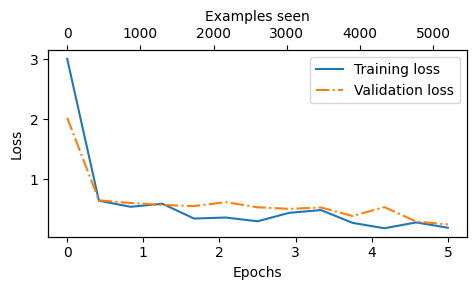

In [65]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- Above, based on the downward slope, we see that the model learns well
- Furthermore, the fact that the training and validation loss are very close indicates that the model does not tend to overfit the training data
- Similarly, we can plot the accuracy below

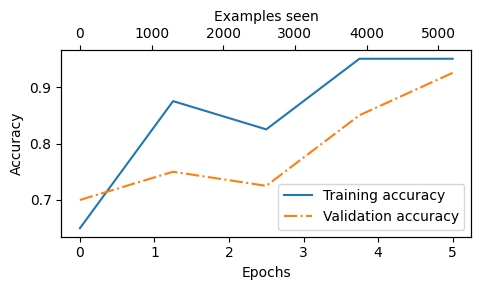

In [66]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

- Based on the accuracy plot above, we can see that the model achieves a relatively high training and validation accuracy after epochs 4 and 5
- However, we have to keep in mind that we specified `eval_iter=5` in the training function earlier, which means that we only estimated the training and validation set performances
- We can compute the training, validation, and test set performances over the complete dataset as follows below

In [67]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 98.17%
Validation accuracy: 95.30%
Test accuracy: 97.67%


- We can see that the training and validation set performances are practically identical
- However, based on the slightly lower test set performance, we can see that the model overfits the training data to a very small degree, as well as the validation data that has been used for tweaking some of the hyperparameters, such as the learning rate
- This is normal, however, and this gap could potentially be further reduced by increasing the model's dropout rate (`drop_rate`) or the `weight_decay` in the optimizer setting

## Step 6 : Using the LLM as a spam classifier

- Finally, let's use the finetuned GPT model in action
- The `classify_review` function below implements the data preprocessing steps similar to the `SpamDataset` we implemented earlier
- Then, the function returns the predicted integer class label from the model and returns the corresponding class name

In [68]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

- Let's try it out on a few examples below

In [69]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [70]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


- Finally, let's save the model in case we want to reuse the model later without having to train it again

In [71]:
torch.save(model.state_dict(), "review_classifier.pth")

- Then, in a new session, we could load the model as follows

In [72]:
model_state_dict = torch.load("review_classifier.pth", map_location=device, weights_only=True)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## Summary and Takeaways

In this notebook, we explored various aspects of fine-tuning a pre-trained GPT model using PyTorch. The process involved several key components and methodologies designed to optimize model performance and training efficiency. 

### Key Components Covered

1. **Data Preparation**: We began by effectively splitting our dataset into training, validation, and test sets using different methods. This ensured that our model could be trained and evaluated properly without overfitting.

2. **Model Definition**: The architecture of our GPT model was defined, taking into account the specific requirements for our classification task. 

3. **Training Loop**: We implemented a straightforward yet efficient training loop, which included:
   - Calculation of loss using cross-entropy.
   - Tracking of correct predictions for accuracy evaluation.
   - Optimization through backpropagation with the AdamW optimizer.

4. **Validation Process**: After each epoch, we evaluated the model's performance on a validation set to gauge its generalization capability.

5. **Modular Approach with FineTuner Class**: We encapsulated the training logic within a `FineTuner` class to promote code reusability and organization. This class includes methods for training, evaluation, and fine-tuning the model.

### Key Takeaways

1. **Simplicity Over Complexity**: A simple training loop can yield excellent results without the overhead of advanced techniques. Our approach achieved a notable accuracy of 97% in a short training time on a single GPU.

2. **Regular Evaluation is Crucial**: Evaluating the model on a validation set after each training epoch provides vital feedback on its performance, helping to avoid overfitting and ensuring better generalization.

3. **Modular Design for Flexibility**: The use of a modular class like `FineTuner` allows for easy updates and modifications in future projects, making it adaptable to varying needs.

4. **Focus on Fundamentals**: Understanding the core principles of training and evaluating neural networks can lead to better results, even when more complex methods are available.

5. **Resource Management**: Efficient use of computational resources (like using the correct device) is essential for maximizing performance and minimizing training time.

By synthesizing these insights and methodologies, practitioners can effectively fine-tune models and achieve high performance while maintaining clarity and efficiency in their training processes.


## 🎉 Congratulations, You Made It! 🎉

You've just conquered this notebook, and what an adventure it has been! You've taken your first steps into the exciting world of building a large language model (LLM) from scratch. Sure, we tackled a classic machine learning problem—text classification—but don’t underestimate it! This journey is like laying the first brick of a grand castle that will be your foundation for more ambitious projects ahead. 

Your hard work here is paving the way for some truly awesome applications, and you're building a rock-solid intuition that will serve you well as we dive deeper into the realm of natural language processing.

### 🚀 What’s Coming Up Next?

But wait, the fun isn’t over! In our next notebook, we’ll be taking things up a notch with **instruction following**. Get ready to watch your model learn how to follow user instructions like a pro—it’s going to be a game changer!

And that's not all! We'll also explore some nifty techniques for optimized fine-tuning, including **LoRA (Low-Rank Adaptation)** and **QLoRA (Quantized Low-Rank Adaptation)**. Trust me, these tools are like secret weapons that will make your models even more efficient and powerful.

Thank you for bringing your energy and enthusiasm to this notebook! Buckle up; the next leg of our journey promises to be just as thrilling! Let’s keep the momentum going! 🚀💪
